# Bug prediction with Recurrent Neural Networks with LSTM
In this notebook we explore the possiblity of utilizing a sequential model to detect logical bugs in source code. We are using a similar technique in deep learning called sentiment analysis to analize a piece of code. The idea behind this approach is fairly simple, we look at a small snippet of code to determine whether the code is buggy or non-buggy.

This notebook will cover some machine learning topics such as recurrent neural networks and long short-term memory units (LSTM). We also breifly discuss techniques for padding squences in tensorflow. 

# Word Embeddings for source code
In order to understand how deep leaning can be applied to analize source code, one interesting technique is by creating word embeddings for each word in the code. To understand why we use word embeddings, we need to think about how neural networks work. For a neural network to run efficently the dot products of matrices are often used to make calculations. So, the network will be expecting scalar values, or a vector of scalar values, so it's obvious we will not be able to just feed string values into the model. One approach can be to use one-hot representations to prepair the data, however this medthod doesn't give the model much information about what the word actually means.

For better results we will used word embeddings, which require a machine learning method to generate, namely using a skip-gram model. But we do not need to worry about that as we are using a premade Word2Vec model provided by SciKit Learn.

The embeddings for this project are being generated in the json_to_vector.py file of this project.

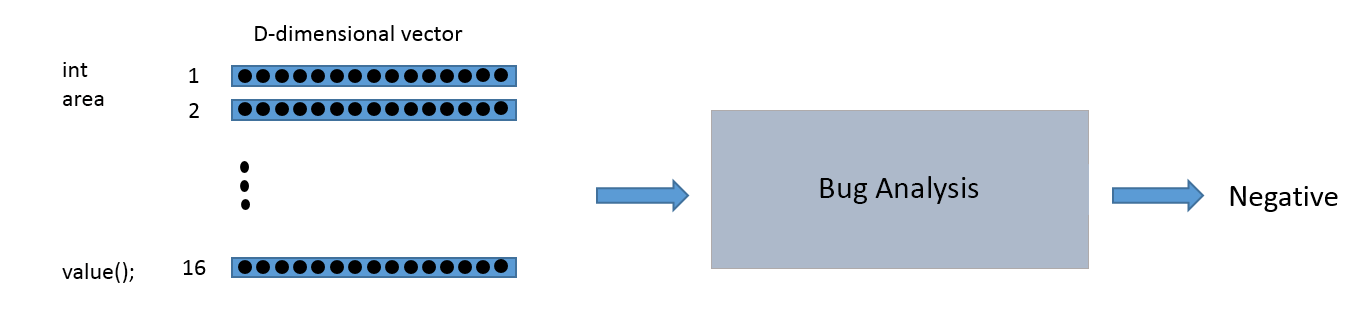

Now when we do this each example we feed into the network our input is now a (number of words in the example) x D-dimensional matrix. The dimension of the embeddings we are currently using is 100 so the above example would be of size (16,100).

The vectors are generated in such a way that each dimension represents a feature and this vector will give the machine some context into what the word means and how it relates to other words.

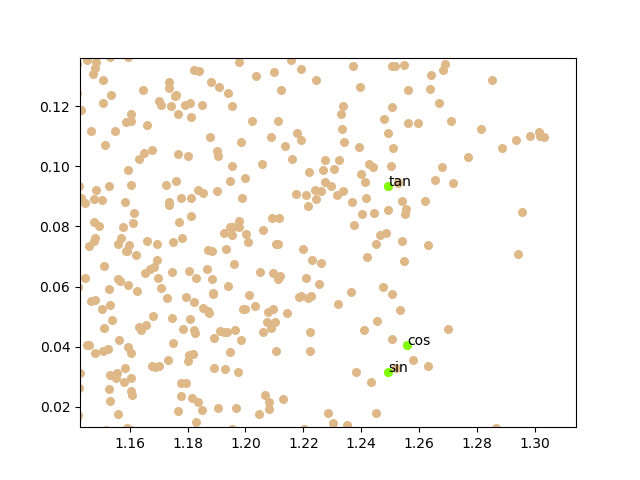

You can see word that have a similar meaning are grouped together, in the example above we can see trig fuctions are grouped next to eachother as you would expect. Before we create these embeddings we are going to tokenize the source code and I will explain how and why we are doing this. The model is taking a large corpus of source code and outputs vectors for each unique word and token. We store the output into an embedding matrix. You can this of this as a dictionary for our model to look up the meaning of a word.

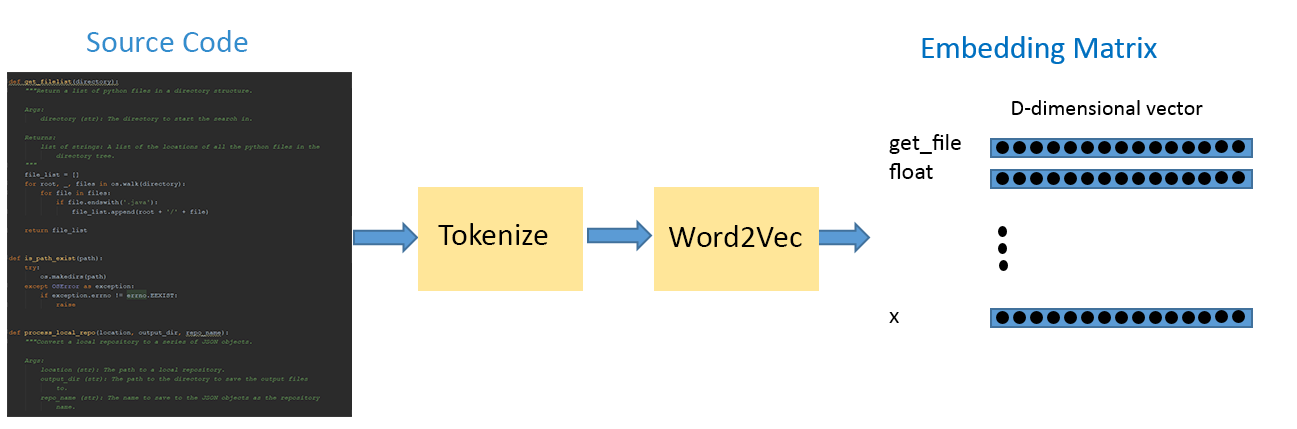

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Embedding
from keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
import json
with open("clean.json") as f:
    clean = json.load(f)
with open("buggy.json") as f:
    buggy = json.load(f)
with open("py2vec_modelJ.json") as f:
    embs = json.load(f)

In [4]:
clean = np.asarray(clean)
buggy = np.asarray(buggy)
buggy_labels = np.ones(len(buggy))
clean_labels = np.zeros(len(clean))

In [5]:
train_data = np.concatenate((clean, buggy), axis=0)
train_labels = np.concatenate((clean_labels, buggy_labels), axis=0)

for i in range(train_data.shape[0]):
    string = ''
    for j in range(len(train_data[i])):
        string += train_data[i][j] + ' '
    train_data[i] = string
    
np.random.seed(3)
np.random.shuffle(train_data)
np.random.shuffle(train_labels)

In [6]:
test_data = train_data[train_data.shape[0]-1000:]
test_labels = train_labels[train_labels.shape[0]-1000:]

In [7]:
train_data = train_data[:train_data.shape[0]-1000]
train_labels = train_labels[:train_labels.shape[0]-1000]

In [8]:
num_words = len(embs)

In [9]:
tokenizer = Tokenizer(num_words=None)

In [10]:
%%time
for i in range(clean.shape[0]):
    string = ''
    for j in range(len(clean[i])):
        string += clean[i][j] + ' '
    clean[i] = string
tokenizer.fit_on_texts(clean)

CPU times: user 360 ms, sys: 0 ns, total: 360 ms
Wall time: 362 ms


In [11]:
train_data_tokens = tokenizer.texts_to_sequences(train_data)
test_data_tokens = tokenizer.texts_to_sequences(test_data)

In [12]:
ndx = tokenizer.word_index
inverse_map = dict(zip(ndx.values(), ndx.keys()))

In [13]:
print(train_data_tokens[2])
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = " ".join(words)
    return text
print(tokens_to_string(train_data_tokens[2]))

[26, 229, 29, 29, 219, 4, 789, 2, 152, 3, 305, 1]
atsignsymbol gwtincompatible divide divide doublemath dispatch roundtoint openparen double comma roundingmode closeparen


In [15]:
vector_size = 100
embedding_matrix = []
embedding_matrix.append(np.zeros(vector_size))
for i in range(1, len(inverse_map)+1):
    if inverse_map[i] in embs:
        embedding_matrix.append(embs[inverse_map[i]])
    elif '_' + str(inverse_map[i]) + '_' in embs:
        embedding_matrix.append(embs['_'+str(inverse_map[i])+'_'])
    else:
        embedding_matrix.append(np.zeros(vector_size))
        print(inverse_map[i])

customfieldserializerbase
candidates
getrandomelement
expectdistinct
setvaluefortesting
populateforrowkeyset
0xfffffffffffffffel
saturatedmultiply
ofentries
group2item2
expiring
setscale
iia1
assertlessthan
removefromchain
threadrenaming
smalllazystriped
largelazystriped
returnedvalue
runfailuretest
runsuppressionfailuretest
skipfully
assertcancelled
suppler
asserttimenotpassed
safecontainskey
encouraged
removeentryfromchain
safecontains
classify
mixh1
trimandcollapsefrom
japanesetointeger
checknooutput
utf8lengths
roundtrippable
isin
isexpired
durationinnanos
reclaimkey
comparefalsefirst
unsafecompare
newroot
escapeslow
timedjoin
group1item3
createtree
integertospanish
getparametersforsignature
3600
entrythree
dont
builderarray
removeoccurrences
containsoccurrences
symmetricdifference
escapeasstring
checktransitiveclosure
createfilledpairedstatsaccumulator
radixencodeparseandassertequals
0xff1a618b7f65ea12l
assertsuccessful
sendrequest
createadversarialinput
foopath
closedtablesize
ol

In [16]:
embedding_matrix = np.asarray(embedding_matrix)

In [17]:
num_tokens = [len(tokens) for tokens in train_data_tokens + test_data_tokens]
num_tokens = np.array(num_tokens)

In [18]:
np.mean(num_tokens)

14.201256821564412

In [19]:
np.max(num_tokens)

54

In [20]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

27

In [21]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9378755305661209

In [22]:
max_tokens = np.max(num_tokens)

In [23]:
pad = 'pre'

In [24]:
train_data_pad = pad_sequences(train_data_tokens, maxlen=max_tokens,
                              padding=pad, truncating=pad)

In [25]:
test_data_pad = pad_sequences(test_data_tokens, maxlen=max_tokens,
                             padding=pad, truncating=pad)

In [26]:
train_data_pad.shape

(35282, 54)

In [27]:
np.array(train_data_pad[0])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  23,  65,  40, 170,   2, 110,   3,  34,   1,
        18,   4], dtype=int32)

In [28]:
from keras.layers import Dropout
num_words = len(inverse_map)
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                   output_dim=embedding_matrix.shape[1],
                   input_length=max_tokens,
                   weights=[embedding_matrix],
                   trainable=False,
                   name='embedding_layer'))
#model.add(Embedding(input_dim=num_words,
#                   output_dim=100,
#                   input_length=max_tokens,
#                   name='embedding_layer'))
model.add(CuDNNLSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(8))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

Instructions for updating:
Use the retry module or similar alternatives.


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 54, 100)           425600    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 54, 16)            7552      
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 16)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 8)                 832       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 433,993
Trainable params: 8,393
Non-trainable params: 425,600
_________________________________________________________________


In [30]:
%%time
model.fit(train_data_pad, train_labels,
         validation_split=0.05, epochs=10, batch_size=64)

Train on 33517 samples, validate on 1765 samples
Epoch 1/10
33517/33517 [==============================] - 8s 232us/step - loss: 0.6936 - acc: 0.5009 - val_loss: 0.6929 - val_acc: 0.5144
Epoch 2/10
33517/33517 [==============================] - 5s 162us/step - loss: 0.6933 - acc: 0.5045 - val_loss: 0.6929 - val_acc: 0.5082
Epoch 3/10
33517/33517 [==============================] - 5s 161us/step - loss: 0.6931 - acc: 0.5036 - val_loss: 0.6936 - val_acc: 0.4935
Epoch 4/10
33517/33517 [==============================] - 5s 161us/step - loss: 0.6928 - acc: 0.5080 - val_loss: 0.6930 - val_acc: 0.5014
Epoch 5/10
33517/33517 [==============================] - 5s 163us/step - loss: 0.6927 - acc: 0.5113 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 6/10
33517/33517 [==============================] - 6s 169us/step - loss: 0.6925 - acc: 0.5143 - val_loss: 0.6938 - val_acc: 0.4980
Epoch 7/10
33517/33517 [==============================] - 5s 162us/step - loss: 0.6922 - acc: 0.5167 - val_loss: 0.6937 - v

In [31]:
result = model.evaluate(test_data_pad, test_labels)

1000/1000 [==============================] - 0s 158us/step


In [32]:
print("accuracy: {0:.2%}".format(result[1]))

accuracy: 47.70%
